# Testing strategy

## SIR Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
%matplotlib inline

In [2]:
# sir_inference imports
from inference_model import MeanField, DynamicMessagePassing
from sir_model import (
    ProximityModel, patient_zeros_states, frequency, indicator,
    random_observations, infected_observations,
)

In [3]:
seed = 878            # seed for reproducibility
np.random.seed(seed)
N = 4000              # number of individuals
N_patient_zero = 20   # number of patients 0
scale = 1.0           # scale of the graphs
mu = 0.01             # mu -> recover
lamb = 0.02           # lamb -> transmission

In [4]:
# to have same result as previous notebook
def patient_zeros_states(N, N_patient_zero):
    states = np.zeros(N)
    patient_zero = np.random.randint(N, size = N_patient_zero)
    states[patient_zero] = 1
    return states

In [5]:
initial_states = patient_zeros_states(N, N_patient_zero)
model = ProximityModel(N, scale, mu, lamb, initial_states)
print("expected number of contacts %.1f" % model.n_contacts)
model.run(300, print_every=50)

expected number of contacts 6.0
Generating transmissions
Running simulation
t = 0 / 300
t = 50 / 300
t = 100 / 300
t = 150 / 300
t = 200 / 300
t = 250 / 300


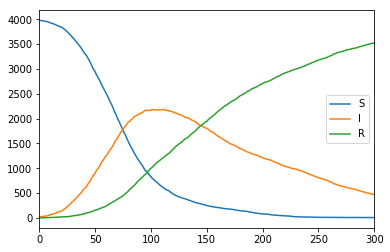

In [6]:
model.get_counts().plot();

In [7]:
interact(model.plot, t=IntSlider(min=0, max=50));

interactive(children=(IntSlider(value=0, description='t', max=50), Output()), _dom_classes=('widget-interact',…

## Validation scenario 

We have a limited budget of new tests to perform and we want to efficiently target the tests.

We compare two testing strategies

1. naive contact tracing : list the contacts of the known infected individuals
2. inference : estimate the probabilities and provide a list of the most probably infected persons

Remarks
- we don't know when they got infected. Maybe in another scenario we can have an informed estimate of that time (eg based on symptoms or other features). Here will do a coarse approximation and say they were all infected at time t_test - tau, where tau is chosen.
- for naive contact tracing, here we simply count the number of encounters during t_test-tau and t_test with the known infected individuals.

## Observations

Let's say we have done a series of random tests in the past, at time `t_test` we have `n_test` of individuals returned positive to the virus.

In [8]:
t_test, n_test = 50, 100
# random observations for t = 0 to t_test - 1
tests = {t: t//2 for t in range(t_test)}
observations = random_observations(model, tests)
# n_test infected people at t_test
observations += infected_observations(model, t_test, n_test)
# let's choose tau
tau = 5
for obs in observations:
    obs["s"] = int(obs["s"])
    obs["tau"] = tau

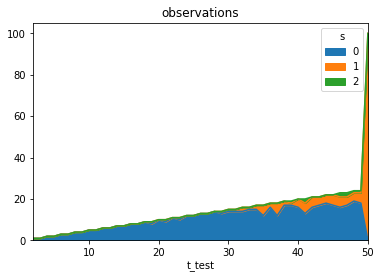

In [9]:
df_observations = pd.DataFrame(observations)
df_observations.groupby(["t_test", "s"]).size().unstack("s").plot.area(
    stacked=True, title="observations"
);

## Naive contact tracing

In [10]:
def csr_to_list(x):
    x_coo = x.tocoo()
    return zip(x_coo.row, x_coo.col, x_coo.data)

# contacts with last_tested people during [t_test - tau, t_test]
last_tested = set(obs["i"] for obs in observations if obs["s"]==1 and obs["t_test"]==t_test)
contacts = pd.DataFrame(
    dict(i=i, j=j, t=t) 
    for t in range(t_test - tau, t_test)
    for i, j, _ in csr_to_list(model.transmissions[t])
    if j in last_tested
)
# count number of encounters
encounters = contacts.groupby("i").size().rename("count").reset_index()
encounters.head()

,i,count
0,0,1
1,1,7
2,8,3
3,10,1
4,11,1


## Inference


Let's say we start the inference at t_start, we can:
- either use MeanField or DynamicMessagePassing as the inference algorithm
- either use the actual frequencies at t_start, or all healthy state at t_start, as the initial proba.

**Warning** One must be careful to shift the transmissions and the observations by t_start !

In [11]:
from time import time
def get_probas(t_start, init, algo):
    # initial probas = all healthy or actual frequency at t_start
    print(f"start inference at t_start = {t_start}")
    if (init=="all_healthy"):
        print("initial_probas = all healthy")
        initial_probas = indicator(np.zeros(model.N))
    else:
        print("initial_probas = actual frequency")
        initial_probas = frequency(model.states[t_start]) 
    # algo = MeanField or DMP
    if (algo=="MF"):
        print("Using MeanField")
        infer = MeanField(initial_probas, model.x_pos, model.y_pos)
    else:
        print("Using DynamicMessagePassing")
        infer = DynamicMessagePassing(initial_probas, model.x_pos, model.y_pos)
    # shift transmissions and observations by t_start
    transmissions = model.transmissions[t_start:t_test + 1]
    for obs in observations:
        obs["t"] = obs["t_test"]-t_start
        obs["t_I"] = obs["t"]-obs["tau"]
    # run inference
    tic = time()
    infer.time_evolution(model.recover_probas, transmissions, observations, print_every=100)
    tac = time()
    print(f"Inference took {tac-tic:.2f}s")
    assert np.allclose(infer.probas.sum(axis=2),1)
    assert infer.probas.min()>=0
    assert infer.probas.max()<=1
    # return probas[t_test]
    probas = pd.DataFrame(infer.probas[t_test-t_start,:,:], columns=["p_S", "p_I", "p_R"])
    probas["p_IR"] = probas["p_I"]+probas["p_R"]
    probas["i"] = np.arange(model.N)
    return probas

In [12]:
probas_MF = get_probas(0, "freqs", "MF")
probas_MF_all_healthy = get_probas(0, "all_healthy", "MF")

start inference at t_start = 0
initial_probas = actual frequency
freqs =  [0.995, 0.005, 0.0]
Using MeanField
t = 0 / 51
Inference took 0.06s
start inference at t_start = 0
initial_probas = all healthy
Using MeanField
t = 0 / 51
Inference took 0.05s


In [13]:
probas_DMP = get_probas(0, "freqs", "DMP")
probas_DMP_all_healthy = get_probas(0, "all_healthy", "DMP")

start inference at t_start = 0
initial_probas = actual frequency
freqs =  [0.995, 0.005, 0.0]
Using DynamicMessagePassing
t = 0 / 51
Inference took 97.86s
start inference at t_start = 0
initial_probas = all healthy
Using DynamicMessagePassing
t = 0 / 51
Inference took 68.12s


## Random guess

As a sanity check.

In [13]:
def get_random_guess(N):
    random_score = np.random.rand(N)
    df = pd.DataFrame({"i": range(N), "score":random_score})
    return df

random_guess = get_random_guess(model.N)

## Comparison

In [14]:
def get_actual_status(target):
    # target states = I or IR
    target_states = []
    if (target=="I"):
        target_states = [1]
    elif (target=="IR"):
        target_states = [1, 2]
    else:
        raise ValueError("target must be 'I' or 'IR'")
    already_tested = set(obs["i"] for obs in observations if obs["s"] in target_states)
    print(f"{len(already_tested)} individuals tested {target} in the observations")
    # pool to target : everyone except already tested
    actual_status = pd.DataFrame(
        dict(i=i, s=s) 
        for i, s in enumerate(model.states[t_test])
        if i not in already_tested
    )
    actual_status["target"] = actual_status["s"].isin(target_states)
    return actual_status


def get_ranked(df, actual_status, score):
    ranked = pd.merge(df, actual_status, on="i", how="inner")
    ranked = ranked.sort_values(by=score, ascending=False)
    ranked["rank"] = np.arange(ranked.shape[0]) + 1
    ranked["total_target"] = ranked["target"].cumsum()
    return ranked


def plot_detected(ax, strategies, target, nlim):
    actual_status = get_actual_status(target)
    ax.plot([0,nlim], [0,nlim], label="perfect")
    score_names = {"random":"score", "tracing":"count"}
    for name, strategy in strategies.items():
        score = score_names.get(name, f"p_{target}")
        ranked = get_ranked(strategy, actual_status, score)
        ax.plot(ranked["rank"], ranked["total_target"], label=name)
    ax.legend()
    ax.set(xlim=(0,nlim), ylim=(0,nlim), xlabel="number of tests", ylabel=f"detected {target}")

In [15]:
probas_BP = pd.read_csv("data/ranks_2000.csv")
probas_BP.columns=["i", "p_IR"]
probas_BP["p_I"] = probas_BP["p_IR"]
probas_BP.head()

,i,p_IR,p_I
0,273,1.00008,1.00008
1,76,1.00006,1.00006
2,155,1.00005,1.00005
3,101,1.00005,1.00005
4,2519,1.00004,1.00004


164 individuals tested I in the observations
164 individuals tested I in the observations


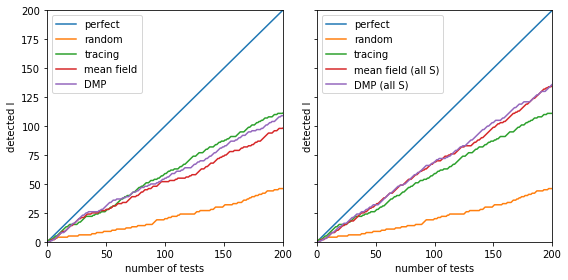

In [16]:
fig, axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
startegies = {
    "random":random_guess, "tracing":encounters, 
    "mean field":probas_MF, "DMP":probas_DMP
}
plot_detected(axs[0], startegies, target="I", nlim=200)
startegies = {
    "random":random_guess, "tracing":encounters, 
    "mean field (all S)":probas_MF_all_healthy, 
    "DMP (all S)":probas_DMP_all_healthy
}
plot_detected(axs[1], startegies, target="I", nlim=200)
fig.tight_layout()

173 individuals tested IR in the observations
173 individuals tested IR in the observations
173 individuals tested IR in the observations


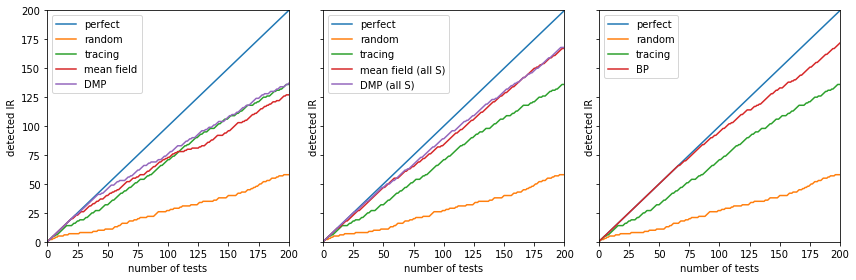

In [17]:
fig, axs = plt.subplots(1,3,figsize=(12,4),sharey=True)
startegies = {
    "random":random_guess, "tracing":encounters, 
    "mean field":probas_MF, "DMP":probas_DMP
}
plot_detected(axs[0], startegies, target="IR", nlim=200)
startegies = {
    "random":random_guess, "tracing":encounters, 
    "mean field (all S)":probas_MF_all_healthy, 
    "DMP (all S)":probas_DMP_all_healthy
}
plot_detected(axs[1], startegies, target="IR", nlim=200)
startegies = {
    "random":random_guess, "tracing":encounters, 
    "BP":probas_BP
}
plot_detected(axs[2], startegies, target="IR", nlim=200)
fig.tight_layout()

## Saving

In [18]:
import os, json
from datetime import datetime

def dump_data():
    # create data_dir
    data_dir = "data_" + datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    print(f"Saving in {data_dir}")
    os.mkdir(data_dir)
    # save params as json
    params = dict(
        seed=seed, N=N, scale=scale, mu=mu, lamb=lamb,
        N_patient_zero=N_patient_zero, 
        t_test=t_test, n_test=n_test, tau=tau
    )
    filename = os.path.join(data_dir, "params.json")
    json.dump(params, open(filename, "w"), indent=4, separators=(',', ': '))
    # save tables as csv
    df_transmissions = pd.DataFrame(
        dict(t=t, i=i, j=j, lamb=lamb) 
        for t, A in enumerate(model.transmissions[:t_test + 1]) 
        for i, j, lamb in csr_to_list(A)
    )
    print("df_transmissions", df_transmissions.shape)
    assert df_transmissions["t"].max()==t_test
    df_transmissions.to_csv(
        os.path.join(data_dir, "transmissions.csv"), 
        index=False
    )
    df_observations = pd.DataFrame(observations)
    df_observations.drop(columns=["t_I", "tau", "t"], inplace=True)
    print("df_observations", df_observations.shape)
    assert df_observations["t_test"].max()==t_test
    df_observations.to_csv(
        os.path.join(data_dir, "observations.csv"), 
        index=False
    )
    df_states = pd.DataFrame(model.states[:t_test + 1,:])
    print("df_states", df_states.shape)
    df_states.to_csv(
        os.path.join(data_dir, "states.csv"), 
        index=False, header=False
    )
    probas_MF.to_csv(os.path.join(data_dir, "probas_MF.csv"), index=False)
    probas_DMP.to_csv(os.path.join(data_dir, "probas_DMP.csv"), index=False)
    probas_MF_all_healthy.to_csv(os.path.join(data_dir, "probas_MF_all_healthy.csv"), index=False)
    probas_DMP_all_healthy.to_csv(os.path.join(data_dir, "probas_DMP_all_healthy.csv"), index=False)
    encounters.to_csv(os.path.join(data_dir, "encounters.csv"), index=False)
    return data_dir

In [19]:
data_dir = dump_data()

Saving in data_2020_04_20_11_17_05
df_transmissions (1227206, 4)
df_observations (700, 3)
df_states (51, 4000)


In [20]:
ls -lh {data_dir}

total 47032
-rw-r--r--  1 antoinebaker  staff   9,1K 20 avr 11:17 encounters.csv
-rw-r--r--  1 antoinebaker  staff   6,5K 20 avr 11:17 observations.csv
-rw-r--r--  1 antoinebaker  staff   163B 20 avr 11:17 params.json
-rw-r--r--  1 antoinebaker  staff   315K 20 avr 11:17 probas_DMP.csv
-rw-r--r--  1 antoinebaker  staff   330K 20 avr 11:17 probas_DMP_all_healthy.csv
-rw-r--r--  1 antoinebaker  staff   314K 20 avr 11:17 probas_MF.csv
-rw-r--r--  1 antoinebaker  staff   330K 20 avr 11:17 probas_MF_all_healthy.csv
-rw-r--r--  1 antoinebaker  staff   797K 20 avr 11:17 states.csv
-rw-r--r--  1 antoinebaker  staff    20M 20 avr 11:17 transmissions.csv
